<a href="https://colab.research.google.com/github/bdbejarc/Instrumentos-Opticos/blob/main/Entrega_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Importar librerías

import pandas as pd
import matplotlib as mlt
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [ ]:
# Coordenadas de mundo
nm = 1e-9
um = 1e-6
mm = 1e-3
cm = 1e-2

# Longitud de onda
w_length = 450*nm


# # Solo por operación definimos N y M de una imagen 2048 x 2048
# N = 2048 # coordenada X
# M = 2048 # coordenada Y


# Diferenciales, como N y M pendientes por definir para una imagen
dx = dy = 1*um # los diferenciales (tamaño de pixel)

In [ ]:
# Función para graficar complejos
def fun_ploteo_complejo(mat, indicador, escala):
    '''
    mat  es una matriz compleja a plotear
    indicador = I para intensidad, A para amplitud, P para fase
    escala = 1 para nada, 0 para logarítmica
    '''
    if(indicador =="I"):
        mat = np.abs(mat)**2
    elif(indicador == "A"):
        mat = np.abs(mat)
    elif(indicador == "P"):
        mat = np.angle(mat)

    if (escala == 1):
        plt.figure()
        plt.imshow(mat)
        plt.colorbar()
        plt.show()
    else:    
        plt.figure()
        plt.imshow( np.log( mat + 0.0001))
        plt.colorbar()
        plt.show()


In [ ]:
pera_img = cv2.imread('pera.png', 0)              # Lecutra del .csv como un objeto np.array
print(np.shape(pera_img) )

(32, 32)


In [ ]:
gafas_img = cv2.imread('gafas.png', 0)              # Lecutra del .csv como un objeto np.array
print(np.shape(gafas_img) )

(225, 225)


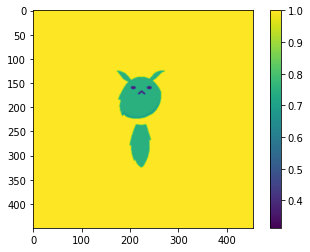

(450, 455)


In [ ]:
dodoco = cv2.imread('dodoco.jpeg', 0)              # Lecutra del .csv como un objeto np.array
dodoco = dodoco/np.max(dodoco)
#dodoco = 255 * (dodo_img - np.min(dodo_img))/(np.max(dodo_img) - np.min(dodo_img))
plt.figure()
plt.imshow(dodoco)
plt.colorbar()
plt.show()
print(np.shape(dodoco))

512


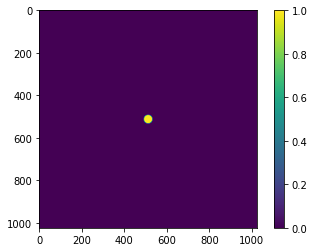

In [ ]:
#Abertura circular

mask = np.zeros((1024,1024), dtype = "uint8")
coord_prev = np.shape(mask)
coord = int(coord_prev[0]/2)
print (coord)
cv2.circle(mask, (coord, coord), 20, 1, -1)
plt.imshow(mask)
plt.colorbar()
plt.show()

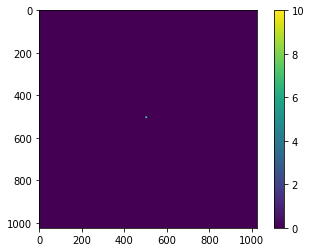

In [ ]:
mask2 = np.zeros((1024,1024), np.uint8)
cv2.rectangle(mask2, (506,506), (500,500),10, -1)
plt.figure()
plt.imshow(mask2)
plt.colorbar()
plt.show()

In [ ]:
def fun_prop_Fresnel(campo, w_length, z, L_x, L_y, dx, dy, fft = True ):
    ''' 
    
    '''
    # Vector de onda
    k_vect = 2*np.pi/w_length

    # Número de muestras
    N_x = int(L_x/dx)
    N_y = int(L_y/dy)

    # delta espacio del plano z=0, satisfaciendo el requerimiento para el kernel de DFT
    dx_0 = (w_length * z)/(dx * N_x)
    dy_0 = (w_length * z)/(dy * N_y)

    # 2. Preparar U'
    # Preparar U', inicialmente una matriz de ceros
    U_prima = np.zeros(np.shape(campo), dtype = np.complex128)


    #  Este bloque de código es equivalente al anterior, pero con la diferencia que se reemplazaron los valores de dx_0 y dy_0
    # para evitar divisiones por cero cuando z=0
    for n_0 in np.arange(N_x):
        for m_0 in np.arange(N_y):
            U_prima[n_0,m_0] = campo[n_0, m_0] * np.exp( (1j*k_vect/(2*z) ) * ( (n_0*dx_0 )**2 + (m_0*dy_0 )**2) )


     # 3. DFT// de U' para obtener U'' en una pisición z
    if fft == False:
          U_2prima = fun_DFT(U_prima, L_x, L_y, dx, dy)
    else:
          U_2prima = np.fft.fftshift(np.fft.fftn(U_prima))


    # 4. Escalar U
    # Inicialmente U como una matriz de ceros
    U_z = np.zeros(np.shape(campo), dtype = np.complex128)

    # Escalar
    for n in np.arange(N_x):
        for m in np.arange(N_y):
            U_z[n,m] = U_2prima[n,m] * np.exp(1j*k_vect*z)/(1j*w_length*z)  * np.exp( k_vect*1j/(2*z) * ( (n*dx)**2 +(m*dy)**2 ) ) 
    
    return U_z


In [ ]:
propagado = fun_prop_Fresnel(pera_img, w_length, 30*um, 32*um,32*um,1*um,1*um, True)
fun_ploteo_complejo(propagado, "I", 1)


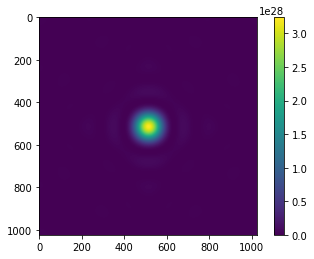

In [ ]:
propagado = fun_prop_Fresnel(mask, w_length, 10*um, 1024*um,1024*um,1*um,1*um, True)
fun_ploteo_complejo(propagado, "I", 1)

In [ ]:
def Fresnel (campo, w_length, z, dx, dy):
    # Vector de onda
    k_vect = 2*np.pi/w_length


    #Definamos el espacio coordenado
    N,M = np.shape(campo)
    x = np.arange(-int(M/2), int(M/2), 1)
    y = np.arange(-int(N/2), int(N/2), 1)
    X,Y = np.meshgrid(x,y)

    # damos dimensiones de mundo
    dx_0 = X * (w_length * z)/(dx * N)
    dy_0 = Y * (w_length * z)/(dy * M) 

    # definimos las fases esféricas
    C1 = np.exp((1j*k_vect/2*z) * ( dx_0**2 + dy_0**2))
    C2 = np.exp((1j*k_vect/z) * (N * dx_0 + M * dy_0))

    # 2. Preparar U'
    U_p = campo * C1

    # 3. DFT// de U' para obtener U'' en una pisición z
    U_2p = np.fft.fftshift(np.fft.fftn(U_p))

    
    # 4. Escalar U
    prop = U_2p * C2

    return prop

In [ ]:
def EspectroAngular (campo, w_length, z, dx, dy):
  # Vector de onda
    k_vect = 2*np.pi/w_length

    #Definamos el espacio coordenado
    N,M = np.shape(campo)
    x = np.arange(-int(M/2), int(M/2), 1)
    y = np.arange(-int(N/2), int(N/2), 1)
    X,Y = np.meshgrid(x,y)

    # damos dimensiones de mundo
    fX = X * (1 / (M*dx))
    fY = Y * (1 / (N*dy))

    # 2. Calculamos el espectro angular discreto A[p,q,0] utilizando FFT.
    A0 = (np.fft.fft2(campo))

    # definimos las fases esféricas 
    C1 = np.exp((1j*k_vect*z) * np.sqrt(1 - (w_length**2)*((fX**2) + (fY**2))))

    # 3. Aplicamos la función de transferencia 
    Az = A0 * C1

    # 4. Calculamos el campo propagado U[n,m,z] como la IFFT del espectro angular propagado y reordenamos
    Uprop = (np.fft.ifftn(Az))

    return Uprop

Prueba de transformada de Fresnel usando una abertura circular

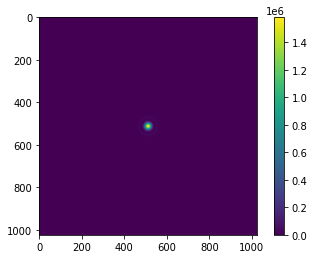

(1024, 1024)

In [ ]:
propFresnelC = Fresnel(mask, w_length, 5*um, dx, dy)
fun_ploteo_complejo(propFresnelC, "I", 1)
np.shape(propFresnelC)

Prueba de espectro angular usando una abertura circular


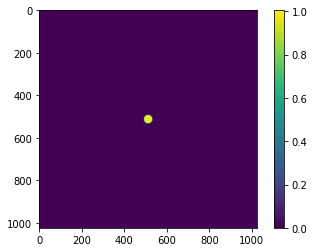

(1024, 1024)

In [ ]:
propASC = EspectroAngular(mask, w_length, 0.4*um, dx, dy)
fun_ploteo_complejo(propaASC, "I", 1)
np.shape(propaASC)

Prueba de Transformada de Fresnel usando una abertura rectangular

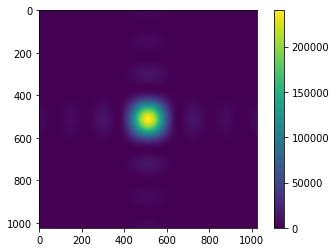

In [ ]:
propFresnelR = Fresnel(mask2, w_length, 1*mm, dx, dy)
fun_ploteo_complejo(propFresnelR, "I", 1)

Prueba de Espectro Angular usando una abertura rectangular


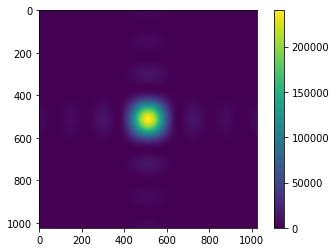

In [ ]:
propASR = Fresnel(mask2, w_length, 0.4*um, dx, dy)
fun_ploteo_complejo(propASR, "I", 1)

In [ ]:
#propag = Fresnel(gafas_img, w_length, 69999*um,1*um,1*um)   #Necesita agregar +1 al meshgrid
#fun_ploteo_complejo(propag, "I", 1)

In [ ]:
#propag = Fresnel(dodoco, w_length, 85*mm,1*um,1*um)
#fun_ploteo_complejo(propag, "I", 1)

Segundo punto, a

In [ ]:
M = 1024
x = np.arange(-int(M/2), int(M/2)+1, 1)
y = x = np.arange(-int(M/2), int(M/2)+1, 1)

X,Y = np.meshgrid(x,y)
np.shape(np.meshgrid(x,y))

def transmitancia (m, L, x):

  for x in np.arange(M):
    y = (1/2) * (1 + (m * np.cos((2* np.pi * x) / L)))
    
  return y

dy_0 = transmitancia(1, dx, x)
#print(dy_0)



NameError: ignored

In [ ]:
M = np.shape(mask[0])
x = np.arange(-int(M/2), int(M/2), 1)

#txy = transmitancia(1, dx, N, x)

#fun_ploteo_complejo(txy, "I", 1)

In [ ]:
propaga = Fresnel(txy, w_length, 10*um, 1*um, 1*um)
fun_ploteo_complejo(propaga, "I", 1)

Segundo punto, b

512


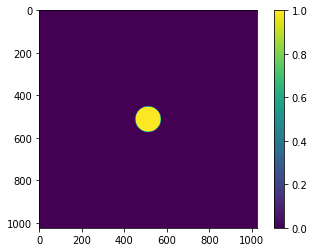

In [ ]:
espaciolibre = np.zeros((1024,1024), dtype = "uint8")
coord_prev = np.shape(espaciolibre)
coord = int(coord_prev[0]/2)
print (coord)
cv2.circle(espaciolibre, (coord, coord), 60, 1, -1)
plt.imshow(espaciolibre)
plt.colorbar()
plt.show()

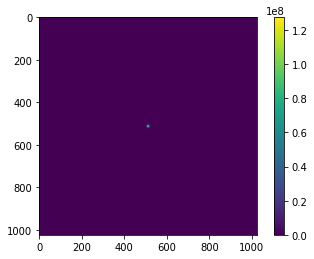

None


In [ ]:
prop_espaciolibre = Fresnel(espaciolibre, w_length, 1*mm, dx, dy)
Ipel = fun_ploteo_complejo(prop_espaciolibre, "I", 1)
print(Ipel)

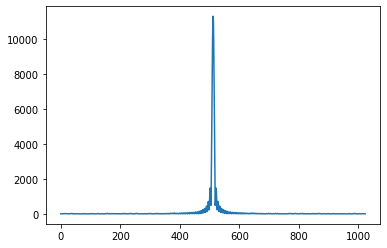

In [ ]:
plt.plot(np.abs(np.diag(prop_espaciolibre)))

512


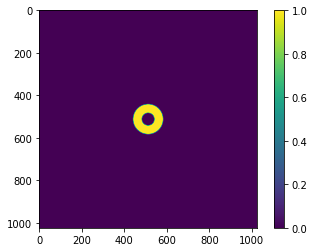

In [ ]:
dona = np.zeros((1024,1024), dtype = "uint8")
coord_prev = np.shape(dona)
coord = int(coord_prev[0]/2)
print(coord)
cv2.circle(dona, (coord, coord), 50, 1, 40)
plt.imshow(dona)
plt.colorbar()
plt.show()

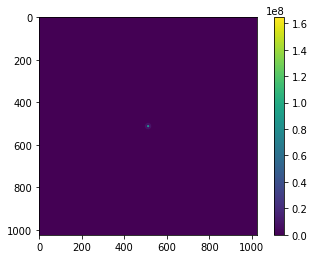

None


In [ ]:
tA = Fresnel(dona, w_length, 1*mm, dx, dy)
I1 = fun_ploteo_complejo(tA, "I", 1)
print(I1)

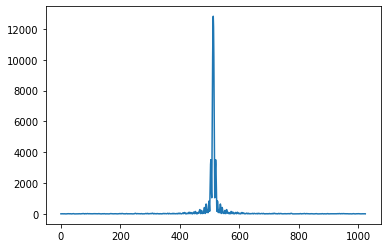

In [ ]:
plt.plot(np.abs(np.diag(tA)))

512


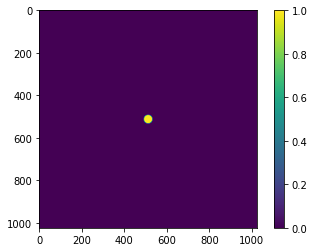

In [ ]:
donacom = np.zeros((1024,1024), dtype = "uint8")
coord_prev = np.shape(donacom)
coord = int(coord_prev[0]/2)
print (coord)
cv2.circle(donacom, (coord, coord), 20, 1, -1)
plt.imshow(donacom)
plt.colorbar()
plt.show()

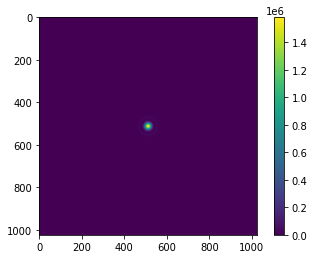

None


In [ ]:
tAcom = Fresnel(donacom, w_length, 1*mm, dx, dy)
I2 = fun_ploteo_complejo(tAcom, "I", 1)
print(I2)

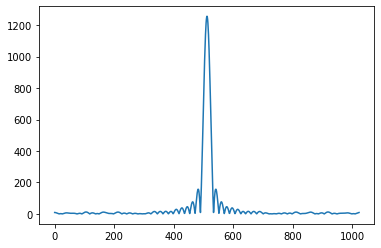

In [ ]:
plt.plot(np.abs(np.diag(tAcom)))

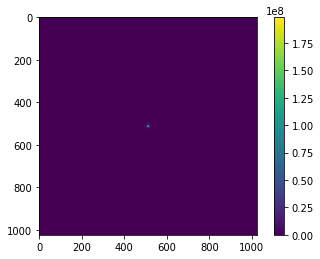

In [ ]:
Suma = tA + tAcom
fun_ploteo_complejo((Suma), "I", 1)

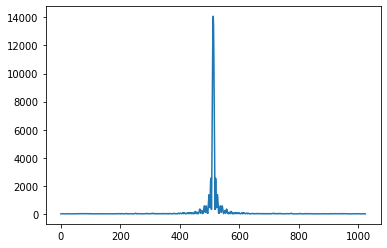

In [ ]:
plt.plot(np.abs(np.diag(Suma)))

Segundo punto, c


512


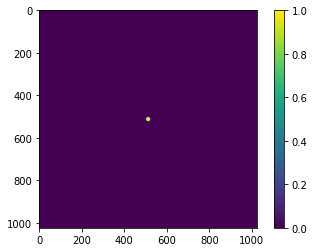

In [ ]:
pinhole = np.zeros((1024,1024), dtype = "uint8")
coord_prev = np.shape(pinhole)
coord = int(coord_prev[0]/2)
print(coord)
cv2.circle(pinhole, (coord, coord), 10, 1, -1)
plt.imshow(pinhole)
plt.colorbar()
plt.show()

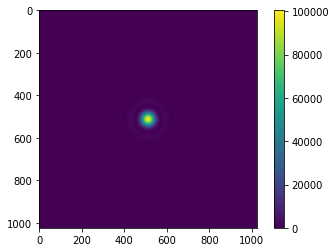

In [ ]:
Arago_prevF = Fresnel(pinhole, w_length, 0.4*um, dx, dy)   #Hacemos propagar desde el pinhole
fun_ploteo_complejo(Arago_prevF, "I", 1)

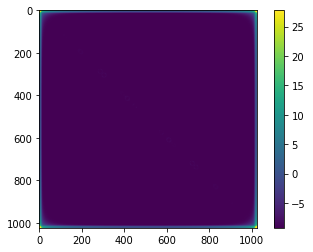

In [ ]:
AragoF = Fresnel(Arago_prevF, w_length, 10*mm, dx, dy)  #Propagamos la interacción del campo con el pinhole hasta la abertura
fun_ploteo_complejo(AragoF, "I", 0)

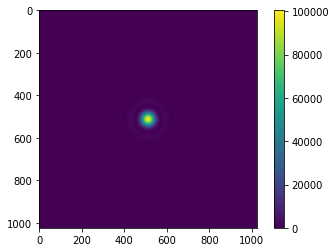

In [ ]:
Arago_prevAS = Fresnel(pinhole, w_length, 0.4*um, dx, dy)   #Hacemos propagar el campo inicial a través del pinhole
fun_ploteo_complejo(Arago_prevAS, "I", 1)

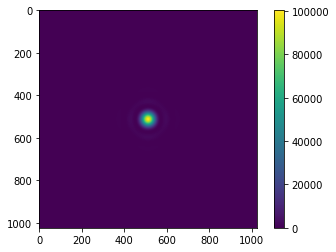

In [ ]:
AragoAS = EspectroAngular(Arago_prevAS, w_length, 1*mm, dx, dy)
fun_ploteo_complejo(AragoAS, "I", 1)

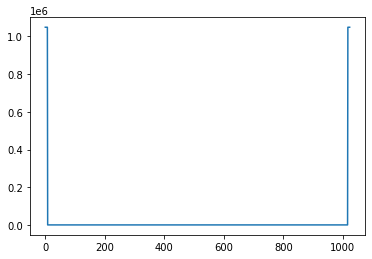

In [ ]:
plt.plot(np.abs(np.diag(AragoF)))

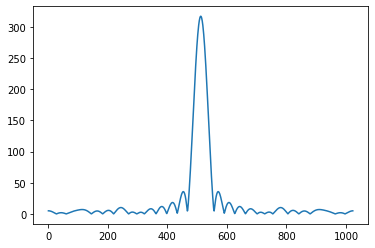

In [ ]:
plt.plot(np.abs(np.diag(AragoAS)))